# Adversarial Variational Optimization: Poisson benchmark

In [1]:
import torch
import cag
import matplotlib.pyplot as plt

In [2]:
from cag.benchmark.poisson import PoissonSimulator as Simulator
from cag.benchmark.poisson import allocate_observations

In [3]:
theta, x_o = allocate_observations(1.9)

In [4]:
simulator = Simulator()

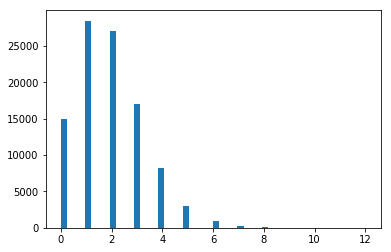

In [5]:
plt.hist(x_o.numpy(), bins=50)
plt.show()

In [6]:
num_hidden = 50
discriminator = torch.nn.Sequential(
    torch.nn.Linear(1, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, 1),
    torch.nn.Sigmoid()
)

In [7]:
from cag.proposal import NormalProposal

proposal = NormalProposal()

In [8]:
from cag.method import AdversarialVariationalOptimization

avo = AdversarialVariationalOptimization(simulator, discriminator, proposal)